# Loading Datasets

In [1]:
import pandas as pd
import numpy as np

# loading datasets
df = pd.read_csv("../data/raw/2022_US_Region_Mobility_Report.csv")
df_cases = pd.read_csv("../data/raw/Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv")

# basic dataset info
df.info()
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747969 entries, 0 to 747968
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 747969 non-null  object 
 1   country_region                                      747969 non-null  object 
 2   sub_region_1                                        747681 non-null  object 
 3   sub_region_2                                        732993 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     14688 non-null   object 
 6   census_fips_code                                    732788 non-null  float64
 7   place_id                                            747969 non-null  object 
 8   date                                                747969 non-n

In [2]:
df

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-01,-43.0,-33.0,-26.0,-41.0,-44.0,12.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-02,-20.0,-12.0,-26.0,-22.0,-17.0,7.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-03,-14.0,-1.0,-24.0,-32.0,-38.0,13.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-04,-14.0,1.0,-19.0,-30.0,-30.0,11.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-05,-16.0,0.0,-19.0,-32.0,-28.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747964,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-10,NaN,NaN,NaN,NaN,-26.0,NaN
747965,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-11,NaN,NaN,NaN,NaN,-20.0,NaN
747966,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-12,NaN,NaN,NaN,NaN,-17.0,NaN
747967,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-13,NaN,NaN,NaN,NaN,-15.0,NaN


In [3]:
df_cases

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,02/23/2023,AZ,02/16/2023,02/22/2023,"2,434,631","3,716","33,042",39,"23,150",0
1,12/22/2022,LA,12/15/2022,12/21/2022,"1,507,707","4,041","18,345",21,"21,397",0
2,02/23/2023,GA,02/16/2023,02/22/2023,"3,061,141","5,298","42,324",88,"6,800",0
3,03/30/2023,LA,03/23/2023,03/29/2023,"1,588,259","2,203","18,858",23,"5,347",0
4,02/02/2023,LA,01/26/2023,02/01/2023,"1,548,508","5,725","18,572",47,"4,507",0
...,...,...,...,...,...,...,...,...,...,...
10375,04/13/2023,WY,04/06/2023,04/12/2023,"186,284",158,"2,023",3,0,0
10376,04/20/2023,WY,04/13/2023,04/19/2023,"186,399",115,"2,027",4,0,0
10377,04/27/2023,WY,04/20/2023,04/26/2023,"186,539",140,"2,030",3,0,0
10378,05/04/2023,WY,04/27/2023,05/03/2023,"186,668",129,"2,031",1,0,0


#### Initial Basic Cleaning

In [4]:
# necessary columns in mobility reports dataset (country, date, mobility percentages)
mobility_columns = ['retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline']

# dropping columns with only null values
df = df.dropna(axis=1, how='all')

# converting 'date' column to actual datetime values
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747969 entries, 0 to 747968
Data columns (total 14 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   country_region_code                                 747969 non-null  object        
 1   country_region                                      747969 non-null  object        
 2   sub_region_1                                        747681 non-null  object        
 3   sub_region_2                                        732993 non-null  object        
 4   iso_3166_2_code                                     14688 non-null   object        
 5   census_fips_code                                    732788 non-null  float64       
 6   place_id                                            747969 non-null  object        
 7   date                                                747969 non-null  datetime64[ns]

C:\Users\Zafarbek\AppData\Local\Temp\ipykernel_13196\888631193.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


#### Initial Data Analysis

In [5]:
# analysis of missing values across the US
rows_before = len(df)
df_clean = df.dropna(subset=mobility_columns, how='any')
rows_after = len(df_clean)

print("Entries before dropping missing values:", rows_before)
print("Entries after dropping missing values:", rows_after)
print("Data loss after dropping missing values:", (round(((rows_before - rows_after)/rows_before*100), 2)),"%")

# analysis of the geographical coverage after cleaning
unique_fips_before = df['census_fips_code'].nunique()
unique_fips_after = df_clean['census_fips_code'].nunique()

print(f"\nUnique FIPS codes before drop: {unique_fips_before}")
print(f"Unique FIPS codes after drop: {unique_fips_after}")
print("FIPS data loss after dropping missing values:", (round(((unique_fips_before - unique_fips_after)/unique_fips_before*100), 2)), "%")

# !!! significant data loss, changing the approach !!!

Entries before dropping missing values: 747969
Entries after dropping missing values: 147224
Data loss after dropping missing values: 80.32 %

Unique FIPS codes before drop: 2810
Unique FIPS codes after drop: 655
FIPS data loss after dropping missing values: 76.69 %


In [6]:
# next approach: aggregating state-level entries to join with cases and deaths reports
df_mobility = df[(df['sub_region_1'].notnull()) & (df['sub_region_2'].isnull())].copy()

df_mobility

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
288,US,United States,Alabama,NaN,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-01,-41.0,-23.0,-15.0,-19.0,-39.0,11.0
289,US,United States,Alabama,NaN,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-02,-19.0,-3.0,-28.0,8.0,-14.0,7.0
290,US,United States,Alabama,NaN,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-03,-12.0,4.0,-24.0,-3.0,-33.0,13.0
291,US,United States,Alabama,NaN,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-04,-8.0,7.0,-20.0,0.0,-20.0,8.0
292,US,United States,Alabama,NaN,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-05,-5.0,11.0,-9.0,0.0,-19.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742701,US,United States,Wyoming,NaN,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-11,3.0,2.0,75.0,16.0,-14.0,1.0
742702,US,United States,Wyoming,NaN,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-12,0.0,-1.0,81.0,18.0,-16.0,0.0
742703,US,United States,Wyoming,NaN,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-13,3.0,2.0,90.0,23.0,-15.0,0.0
742704,US,United States,Wyoming,NaN,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-14,-2.0,1.0,97.0,31.0,-13.0,0.0


# Initial Analysis & Cleanup

#### Cleanup & Feature Engineering

In [7]:
# DATASET JOINING STAGE
# cleaning error data and non-numeric strings
cleaning_columns = ['tot_cases', 'new_cases', 'tot_deaths', 'new_deaths', 'new_historic_cases', 'new_historic_deaths']

for column in cleaning_columns:
    df_cases[column] = df_cases[column].astype(str).str.replace(',', '').astype(float)

# date conversion and column rename
df_cases['end_date'] = pd.to_datetime(df_cases['end_date'])
df_cases.rename(columns={'end_date': 'date', 'state': 'state_code'}, inplace=True)

# filtering for data relevant to 2022 and unnecessary columns clean up
df_cases = df_cases[(df_cases['date'].dt.year == 2022)].copy()
df_cases = df_cases[['date', 'state_code', 'new_cases', 'new_deaths']]
df_cases.dropna(subset=['new_cases'], inplace=True)

# mapping state names
# state name/code mapping dictionary for all possible states
state_name_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
}

# mapping state names
df_mobility['state_code'] = df_mobility['sub_region_1'].map(state_name_to_code)

#### Joining Datasets

In [8]:
df_joined = pd.merge(
    df_mobility,
    df_cases,
    on=['date', 'state_code'],
    how='left'
)
# forward fill the weekly case count to all daily records in that week
df_joined['new_cases_weekly'] = df_joined.groupby('state_code')['new_cases'].ffill()

# dropping null-only columns
df_joined = df_joined.dropna(axis=1, how='all')

# checking the join outcomes
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14688 entries, 0 to 14687
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   country_region_code                                 14688 non-null  object        
 1   country_region                                      14688 non-null  object        
 2   sub_region_1                                        14688 non-null  object        
 3   iso_3166_2_code                                     14688 non-null  object        
 4   census_fips_code                                    288 non-null    float64       
 5   place_id                                            14688 non-null  object        
 6   date                                                14688 non-null  datetime64[ns]
 7   retail_and_recreation_percent_change_from_baseline  14688 non-null  float64       
 8   grocer

# Exploratory Data Analysis

#### Statistical Summary

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

summary = df_joined[mobility_columns].describe().T
print(summary)

                                                      count       mean  \
retail_and_recreation_percent_change_from_baseline  14688.0  -5.769404   
grocery_and_pharmacy_percent_change_from_baseline   14688.0   0.349741   
parks_percent_change_from_baseline                  14645.0  63.537658   
transit_stations_percent_change_from_baseline       14688.0  -6.890319   
workplaces_percent_change_from_baseline             14688.0 -19.818696   
residential_percent_change_from_baseline            14688.0   4.077138   

                                                          std   min   25%  \
retail_and_recreation_percent_change_from_baseline  12.115915 -94.0 -12.0   
grocery_and_pharmacy_percent_change_from_baseline   10.863020 -91.0  -6.0   
parks_percent_change_from_baseline                  80.470368 -67.0   0.0   
transit_stations_percent_change_from_baseline       23.613762 -91.0 -23.0   
workplaces_percent_change_from_baseline             11.155982 -80.0 -26.0   
residential_percent

#### Correlation Matrix

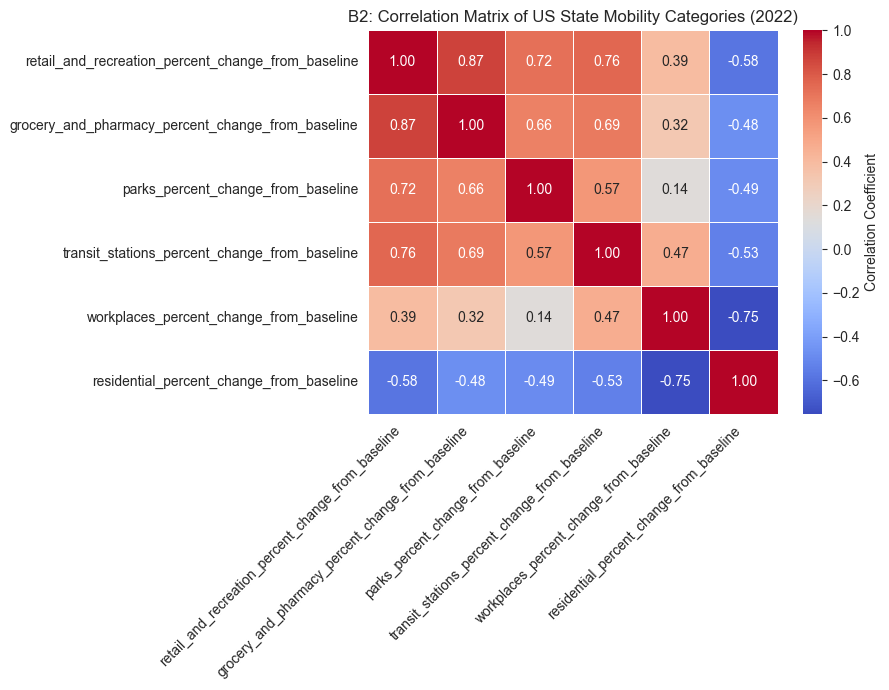

In [10]:
correlation_matrix = df_joined[mobility_columns].corr()
# heatmap visualization
plt.figure(figsize=(9, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('B2: Correlation Matrix of US State Mobility Categories (2022)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

#### Time Series Graphs

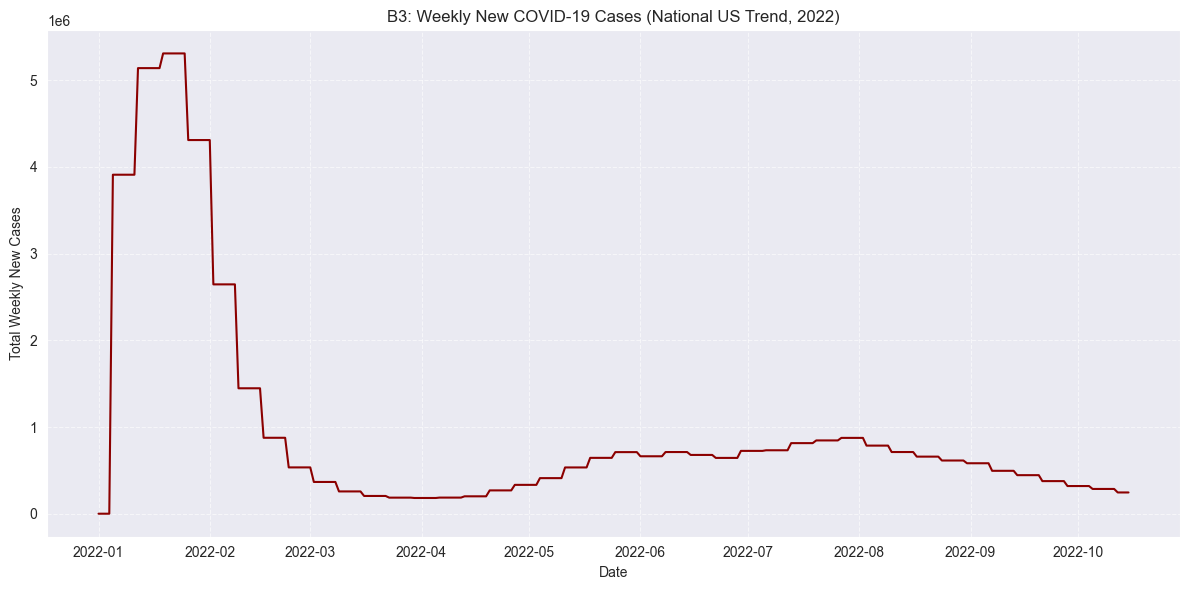

In [11]:
# aggregating plotting weekly cases by date
df_ts_plot = df_joined.groupby('date')['new_cases_weekly'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_ts_plot, x='date', y='new_cases_weekly', color='darkred')
plt.title('B3: Weekly New COVID-19 Cases (National US Trend, 2022)')
plt.xlabel('Date')
plt.ylabel('Total Weekly New Cases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Dataset Preparation

#### Missing values

In [12]:
# imputing missing values in mobility data
for col in mobility_columns:
    df_joined[col] = df_joined.groupby('sub_region_1')[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

# dropping cases with null data
df_final = df_joined.dropna(subset=['new_cases_weekly']).copy()
df_final

,country_region_code,country_region,sub_region_1,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state_code,new_cases,new_deaths,new_cases_weekly
4,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-05,-5.0,11.0,-9.0,0.0,-19.0,7.0,AL,51943.0,49.0,51943.0
5,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-06,-19.0,2.0,-27.0,-9.0,-22.0,12.0,AL,NaN,NaN,51943.0
6,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-07,-17.0,-5.0,-22.0,-11.0,-21.0,11.0,AL,NaN,NaN,51943.0
7,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-08,-15.0,-1.0,-9.0,-7.0,-7.0,6.0,AL,NaN,NaN,51943.0
8,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-09,-23.0,-8.0,-31.0,-12.0,-11.0,8.0,AL,NaN,NaN,51943.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14683,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-11,3.0,2.0,75.0,16.0,-14.0,1.0,WY,NaN,NaN,461.0
14684,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-12,0.0,-1.0,81.0,18.0,-16.0,0.0,WY,427.0,5.0,427.0
14685,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-13,3.0,2.0,90.0,23.0,-15.0,0.0,WY,NaN,NaN,427.0
14686,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-14,-2.0,1.0,97.0,31.0,-13.0,0.0,WY,NaN,NaN,427.0


#### Feature Engineering

In [13]:
# target variable
target_var = 'new_cases_weekly'

# using a lagged 7-day rolling mean to predict the next week's case count
lagged_features = []
for col in mobility_columns:
    df_final[f'{col}_roll7'] = df_final.groupby('sub_region_1')[col].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # Lag the rolling mean by 7 days
    lag_col = f'{col}_roll7_lag7'
    df_final[lag_col] = df_final.groupby('sub_region_1')[f'{col}_roll7'].shift(7)
    lagged_features.append(lag_col)

# dropping rows with null lagged features
df_final.dropna(subset=lagged_features, inplace=True)
df_final

,country_region_code,country_region,sub_region_1,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,...,grocery_and_pharmacy_percent_change_from_baseline_roll7,grocery_and_pharmacy_percent_change_from_baseline_roll7_lag7,parks_percent_change_from_baseline_roll7,parks_percent_change_from_baseline_roll7_lag7,transit_stations_percent_change_from_baseline_roll7,transit_stations_percent_change_from_baseline_roll7_lag7,workplaces_percent_change_from_baseline_roll7,workplaces_percent_change_from_baseline_roll7_lag7,residential_percent_change_from_baseline_roll7,residential_percent_change_from_baseline_roll7_lag7
11,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-12,-10.0,4.0,-6.0,...,0.142857,11.000000,-17.714286,-9.000000,-7.428571,0.000000,-16.285714,-19.000000,8.285714,7.000000
12,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-13,-13.0,5.0,-8.0,...,0.571429,6.500000,-15.000000,-18.000000,-6.714286,-4.500000,-15.714286,-20.500000,7.714286,9.500000
13,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-14,-13.0,2.0,-2.0,...,1.571429,2.666667,-12.142857,-19.333333,-6.000000,-6.666667,-15.571429,-20.666667,7.285714,10.000000
14,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-15,-19.0,1.0,-17.0,...,1.857143,1.750000,-13.285714,-16.750000,-6.428571,-6.750000,-16.142857,-17.250000,7.428571,9.000000
15,US,United States,Alabama,US-AL,NaN,ChIJdf5LHzR_hogR6czIUzU0VV4,2022-01-16,-34.0,-16.0,-35.0,...,0.714286,-0.200000,-13.857143,-19.600000,-8.428571,-7.800000,-17.285714,-16.000000,7.714286,8.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14683,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-11,3.0,2.0,75.0,...,1.142857,5.428571,114.285714,126.285714,22.000000,27.571429,-13.714286,-12.714286,0.000000,-0.285714
14684,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-12,0.0,-1.0,81.0,...,0.714286,5.428571,107.857143,122.428571,22.000000,26.571429,-13.571429,-12.714286,0.000000,-0.285714
14685,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-13,3.0,2.0,90.0,...,0.428571,5.428571,104.142857,119.285714,22.142857,25.428571,-13.571429,-12.571429,0.000000,-0.285714
14686,US,United States,Wyoming,US-WY,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-14,-2.0,1.0,97.0,...,0.714286,4.428571,103.714286,116.714286,21.857143,25.142857,-13.571429,-12.571429,0.000000,-0.285714


#### OneHotEncoder for categorical values

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# separating features for One-Hot Encoding
df_final['day_of_week'] = df_final['date'].dt.day_name()
df_final['month'] = df_final['date'].dt.month.astype(str)

CATEGORICAL_FEATURES = ['sub_region_1', 'day_of_week', 'month']

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

# fit-transforming features
df_encoded = preprocessor.fit_transform(df_final)

# getting feature names
feature_names = preprocessor.get_feature_names_out()

# encoded dataframe
df_final_ohe = pd.DataFrame(df_encoded, columns=feature_names, index=df_final.index)

# Optional: Clean up the column names for a cleaner look, removing the 'cat__' prefix
df_final_ohe.columns = [col.replace('cat__', '') for col in df_final_ohe.columns]

df_final_ohe

,sub_region_1_Alaska,sub_region_1_Arizona,sub_region_1_Arkansas,sub_region_1_California,sub_region_1_Colorado,sub_region_1_Connecticut,sub_region_1_Delaware,sub_region_1_District of Columbia,sub_region_1_Florida,sub_region_1_Georgia,...,remainder__grocery_and_pharmacy_percent_change_from_baseline_roll7,remainder__grocery_and_pharmacy_percent_change_from_baseline_roll7_lag7,remainder__parks_percent_change_from_baseline_roll7,remainder__parks_percent_change_from_baseline_roll7_lag7,remainder__transit_stations_percent_change_from_baseline_roll7,remainder__transit_stations_percent_change_from_baseline_roll7_lag7,remainder__workplaces_percent_change_from_baseline_roll7,remainder__workplaces_percent_change_from_baseline_roll7_lag7,remainder__residential_percent_change_from_baseline_roll7,remainder__residential_percent_change_from_baseline_roll7_lag7
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,11.0,-17.714286,-9.0,-7.428571,0.0,-16.285714,-19.0,8.285714,7.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.571429,6.5,-15.0,-18.0,-6.714286,-4.5,-15.714286,-20.5,7.714286,9.5
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.571429,2.666667,-12.142857,-19.333333,-6.0,-6.666667,-15.571429,-20.666667,7.285714,10.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.857143,1.75,-13.285714,-16.75,-6.428571,-6.75,-16.142857,-17.25,7.428571,9.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,-0.2,-13.857143,-19.6,-8.428571,-7.8,-17.285714,-16.0,7.714286,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.142857,5.428571,114.285714,126.285714,22.0,27.571429,-13.714286,-12.714286,0.0,-0.285714
14684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,5.428571,107.857143,122.428571,22.0,26.571429,-13.571429,-12.714286,0.0,-0.285714
14685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.428571,5.428571,104.142857,119.285714,22.142857,25.428571,-13.571429,-12.571429,0.0,-0.285714
14686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,4.428571,103.714286,116.714286,21.857143,25.142857,-13.571429,-12.571429,0.0,-0.285714


#### Final Columns Separation

In [15]:
# final columns
final_columns = lagged_features + [col for col in df_final.columns if any(df_final[col].name.startswith(f'{cat}_') for cat in CATEGORICAL_FEATURES)]

X = df_final[final_columns]
y = df_final[target_var]

#### Scaling

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[lagged_features] = scaler.fit_transform(X[lagged_features])
X.columns

C:\Users\Zafarbek\AppData\Local\Temp\ipykernel_13196\1082747070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[lagged_features] = scaler.fit_transform(X[lagged_features])


Index(['retail_and_recreation_percent_change_from_baseline_roll7_lag7',
       'grocery_and_pharmacy_percent_change_from_baseline_roll7_lag7',
       'parks_percent_change_from_baseline_roll7_lag7',
       'transit_stations_percent_change_from_baseline_roll7_lag7',
       'workplaces_percent_change_from_baseline_roll7_lag7',
       'residential_percent_change_from_baseline_roll7_lag7'],
      dtype='object')

#### Splitting to train and test

In [17]:
from sklearn.model_selection import train_test_split

# sorting by date, as data is time-series
df_final.sort_values(by='date', inplace=True)

# splitting time-series data without shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(X_train.shape)
print(X_test.shape)


(12714, 6)
(1413, 6)


# Models Training

#### 1. Linear Regression

<Figure size 1200x600 with 0 Axes>

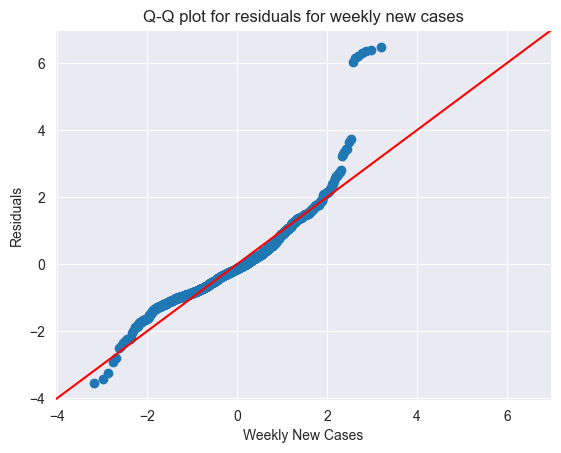

In [18]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# training
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)

# predicting
y_pred_mlr = model_mlr.predict(X_test)

# Q-Q plot for visualization
residuals = y_test - y_pred_mlr
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot for residuals for weekly new cases")
plt.xlabel('Weekly New Cases')
plt.ylabel('Residuals')
plt.show()

#### 2. Random Forest Regressor

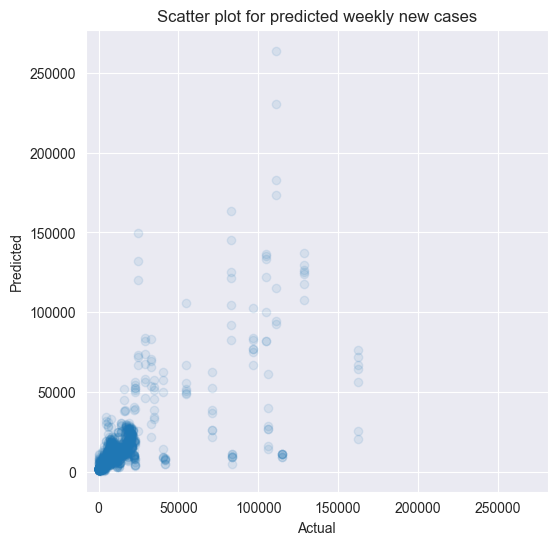

In [19]:
from sklearn.ensemble import RandomForestRegressor

# training
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# predicting
y_pred_rf = model_rf.predict(X_test)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.1)
plt.title("Scatter plot for predicted weekly new cases")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.axis('square')
plt.show()

#### 3. XGBoost Regressor with Grid Search for Hyperparameter Tuning

Fitting 3 folds for each of 16 candidates, totalling 48 fits


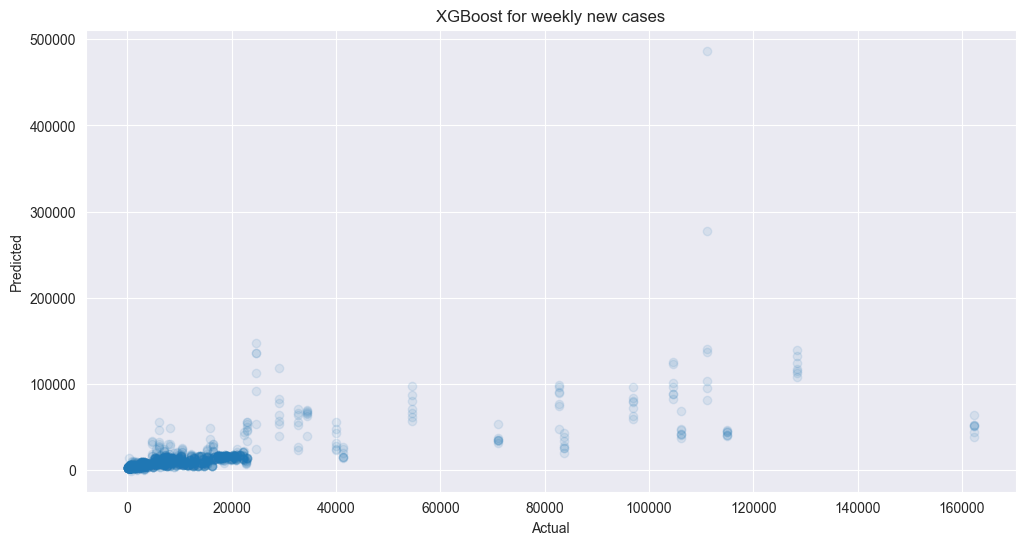

In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.9]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# training
grid_search.fit(X_train, y_train)
model_xgb = grid_search.best_estimator_

# predicting
y_pred_xgb = model_xgb.predict(X_test)

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.1)
plt.title("XGBoost for weekly new cases")
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.grid(True)
plt.show()


# Models Evaluation


Evaluation for Linear Regression:
  Root Mean Squared Error (RMSE): 17482.35
  Mean Absolute Error (MAE): 12816.07
  R-squared: 0.4374

Evaluation for Random Forest Regressor:
  Root Mean Squared Error (RMSE): 17687.08
  Mean Absolute Error (MAE): 7382.35
  R-squared: 0.4241

Evaluation for XGBoost Regressor:
  Root Mean Squared Error (RMSE): 18728.57
  Mean Absolute Error (MAE): 7527.90
  R-squared: 0.3543


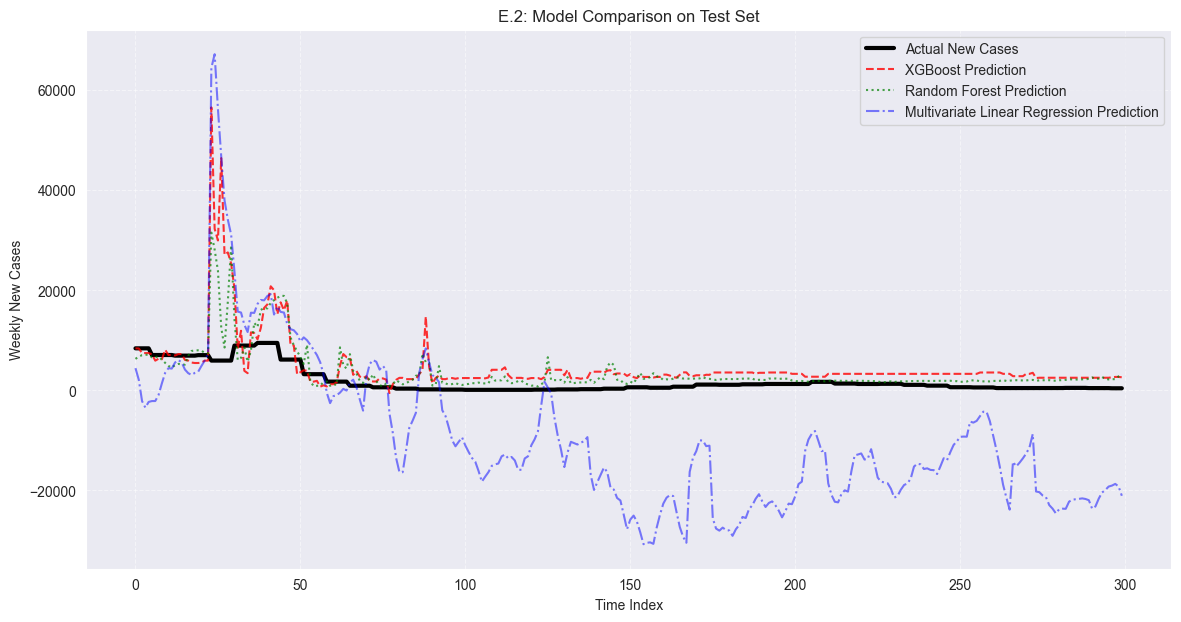

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation function
def evaluate_model(y_pred, y_test, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results for comparison
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R-squared': r2}

    # print results
    print(f"\nEvaluation for {model_name}:")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  R-squared: {r2:.4f}")
    return y_pred

results = {}

# evaluating models
mlr_results = evaluate_model(y_pred_mlr, y_test, "Linear Regression")
rf_results = evaluate_model(y_pred_rf, y_test, "Random Forest Regressor")
xgb_results = evaluate_model(y_pred_xgb, y_test, "XGBoost Regressor")

# compare results
df_results = pd.DataFrame({'Actual': y_test, 'MLR_Pred': y_pred_mlr, 'RF_Pred': y_pred_rf, 'XGB_Pred': y_pred_xgb})

# plot a sample test data
df_sample = df_results.tail(300).reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(df_sample.index, df_sample['Actual'], label='Actual New Cases', color='black', linewidth=3)
plt.plot(df_sample.index, df_sample['XGB_Pred'], label='XGBoost Prediction', linestyle='--', color='red', alpha=0.8)
plt.plot(df_sample.index, df_sample['RF_Pred'], label='Random Forest Prediction', linestyle=':', color='green', alpha=0.7)
plt.plot(df_sample.index, df_sample['MLR_Pred'], label='Multivariate Linear Regression Prediction', linestyle='-.', color='blue', alpha=0.5)

plt.title('E.2: Model Comparison on Test Set')
plt.xlabel('Time Index')
plt.ylabel('Weekly New Cases')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Deployment

#### Saving final model, scaler and features

In [22]:
import joblib

# Save the final model and scaler
joblib.dump(model_mlr, '../joblibs/F1_final_mlr_model.joblib')
joblib.dump(scaler, '../joblibs/F1_feature_scaler.joblib')
joblib.dump(final_columns, '../joblibs/F1_feature_list.joblib')

['../joblibs/F1_feature_list.joblib']

#### Deployment Simulation: Prediction Function

In [23]:
import pandas as pd
import numpy as np

lagged_features = [
    'retail_and_recreation_percent_change_from_baseline_roll7_lag7',
    'grocery_and_pharmacy_percent_change_from_baseline_roll7_lag7',
    'parks_percent_change_from_baseline_roll7_lag7',
    'transit_stations_percent_change_from_baseline_roll7_lag7',
    'workplaces_percent_change_from_baseline_roll7_lag7',
    'residential_percent_change_from_baseline_roll7_lag7'
]

# Deployment Function
def deploy_predict(raw_data_point, model, scaler, feature_columns, mobility_columns):

    X_deploy = pd.DataFrame(0, index=[0], columns=feature_columns)

    raw_mobility_values = [raw_data_point[col] for col in mobility_columns]
    context_inputs = {k: v for k, v in raw_data_point.items() if k not in mobility_columns}

    raw_mobility_array = np.array(raw_mobility_values).reshape(1, -1)
    scaled_mobility_array = scaler.transform(raw_mobility_array)[0]

    for i, col in enumerate(mobility_columns):
        X_deploy.loc[0, col] = scaled_mobility_array[i]

    for col, value in context_inputs.items():
        X_deploy.loc[0, col] = value

    prediction = model.predict(X_deploy)
    return prediction[0]


mock_raw_input = {
    'retail_and_recreation_percent_change_from_baseline_roll7_lag7': -5.0,
    'grocery_and_pharmacy_percent_change_from_baseline_roll7_lag7': 2.0,
    'parks_percent_change_from_baseline_roll7_lag7': 15.0,
    'transit_stations_percent_change_from_baseline_roll7_lag7': -12.0,
    'workplaces_percent_change_from_baseline_roll7_lag7': -18.0,
    'residential_percent_change_from_baseline_roll7_lag7': 4.0,
    'day_of_week_Monday': 1,
    'month_4': 1,
    'sub_region_1_New York': 1,
}